**TP 3 Inférence, dynamique langevienne, diffusion**


**Exercice 1:** (inférence par poussé en avant par le flot)
Ecrire une fonction `sample(fon,n)` qui prend en paramètre une fonction `fon`$:\mathbb{R}^2\rightarrow\mathbb{R}^2$ et échantillone un élément suivant cette densité en échantillonnant un point de $\mathbb{R}^2$ selon une loi normale puis effectue n pas à l'aide du schéma numérique d'Euler.  



In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pkg_ga import get_gradient_function, affichage

#test gradfonction
champv=get_gradient_function()
mu1 = np.array([2,3])
print(champv(mu1))

[-0.06041197647022045, -0.030229710177298585]


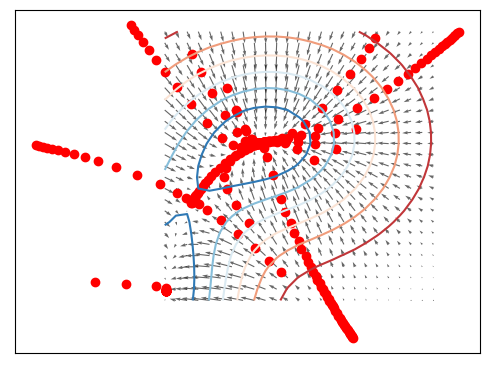

In [ ]:
#fon() is numpy
def integrate(fon, p, n):
    point = p
    liste =np.array(p)
    for i in range(n):
        point = point + fon(point)
        liste=np.vstack((liste,point))
    return liste

def sample(fon, n):
    mu1=np.matrix([[5, 0],[0, 5]])
    depart=np.random.multivariate_normal([2.5,2.5],mu1,n) #l'echantilloner d'une loi normale.
    liste= [integrate(fon,depart[i],30) for i in range(depart.shape[0])]
    return np.concatenate(liste)

liste=sample(champv,15)
affichage(liste)

**Exercice 2:** (évaluation)
Appliquer la fonction sample pour échantilloner à l'aide du champ de vecteur appris au TP précédent. Comparer à un échantillonage de même taille à partir de la loi de probabilité sous-jacente. Faire une représentation graphique des deux échantillonages.
Voyez vous une différence?


La distribution d'un échantillonage poussé en avant par le flot a tendance à se concentrer sur les points de plus haute probabilité. Pour contrer cela on peut à chaque étape du schéma d'Euler rajouter un petit peu de bruit.

**Exercice 3:** (inférence par dynamique langevienne)
Ecrire une fonction `langevin_sample(fon,n)` qui prend en paramètre une fonction `fon`$:\mathbb{R}^2\rightarrow\mathbb{R}^2$ et échantillone un élément suivant cette densité en échantillon un point de $\mathbb{R}^2$ selon une loi normale puis effectue n pas à l'aide du schéma numérique d'Euler, en ajoutant à chaque pas une petite perturbation tirée selon une loi normale.

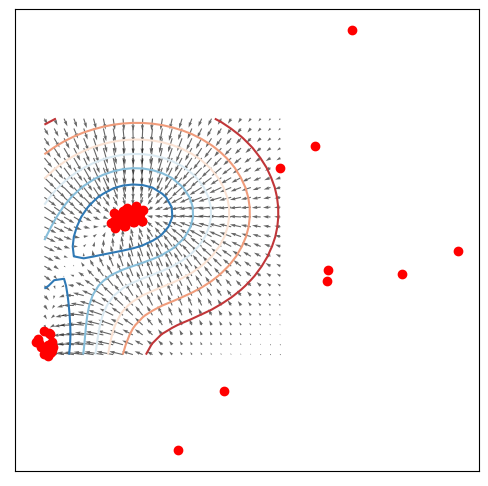

In [3]:
def langevin_sample(fon, p, n, epsi):
    point = p
    liste =np.array(p)
    mu1=np.matrix([[epsi, 0],[0, epsi]])
    for i in range(n):
        point = point + fon(point) + np.random.multivariate_normal([0,0],mu1)
        liste=np.vstack((liste,point))
    return liste



def langevin_samples(fon, n):
    mu1=np.matrix([[5, 0],[0, 5]])
    depart=np.random.multivariate_normal([2.5,2.5],mu1,n) #l'echantilloner d'une loi normale.
    liste= [langevin_sample(fon,depart[i],30,0.01)[-1] for i in range(depart.shape[0])]
    return np.array(liste)

liste2=langevin_samples(champv,100)
affichage(liste2)

**Exercice 4:** (évaluation)
Comparer sur une représentation graphique les échantillonages obtenus à l'aide des fonctions `langevin_sample`, `sample` ainsi qu'à partir de la loi de probabilité sous-jacente.

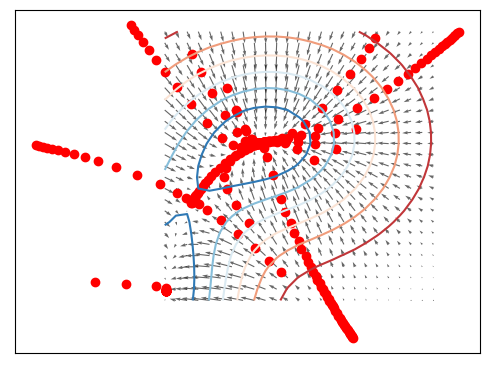

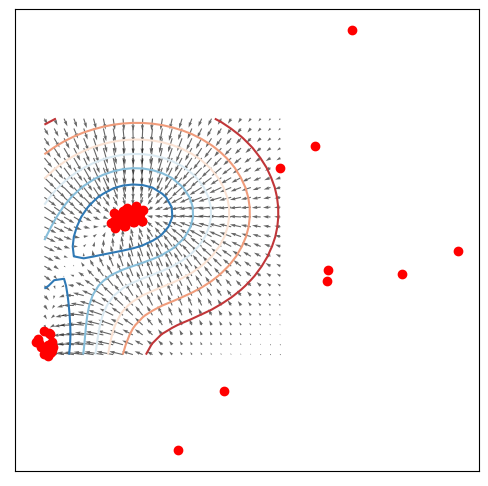

In [4]:
from pkg_new import *

affichage(liste)
affichage(liste2)

**Exercice 5:** (animation)
Faire une animation dynamique (représentation graphique de évolution dans le 'temps') des shémas d'intégration utilisés aux exercices 1 et 3. L'objectif est de reproduire les animations de https://yang-song.net/blog/2021/score/

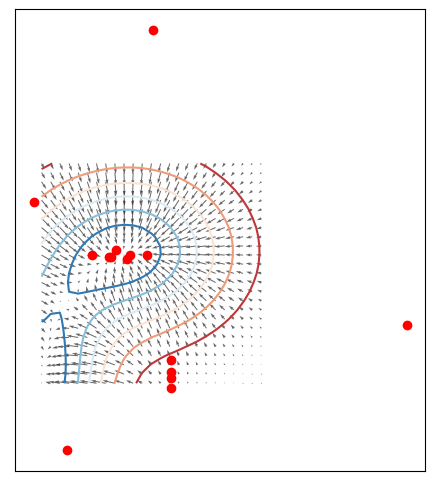

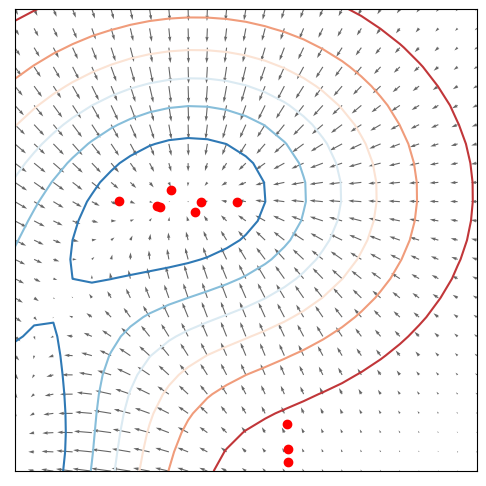

In [5]:

def integrate_new(f, p, steps=30):
    """Integrates a function along a path."""
    path = [p]
    for _ in range(steps):
        p = p + np.array(f(p)) * 0.1  # Small step for smooth animation
        path.append(p)
    return np.array(path)

def sample_new(f, num_samples=15, steps=30):
    """Generates sample points and integrates their paths."""
    cov = np.array([[5, 0], [0, 5]])
    start_points = np.random.multivariate_normal([2.5, 2.5], cov, num_samples)
    trajectories = np.array([integrate_new(f, p, steps) for p in start_points])
    return trajectories


grad_func = get_gradient_function()
points = sample_new(grad_func, num_samples=15, steps=30)
    
# Show static plot
affichage(points[:, -1, :])  # Show final positions
    
# Show animated gradient flow
dynamic_affichage(points, steps=30)

**Exercice 6:** (estimation naive du score)
En se basant sur la méthode vue en cours, apprendre à un réseau de neurones à prédire l'inverse du bruit qui est rajouté à un point des données. Faire une représentation du champs de vecteur associé

In [ ]:
import torch
from torch import nn        #neuronal network
from torch import optim     #descente de gradient
from torch.utils.data import DataLoader
import itertools

from sklearn.model_selection import train_test_split

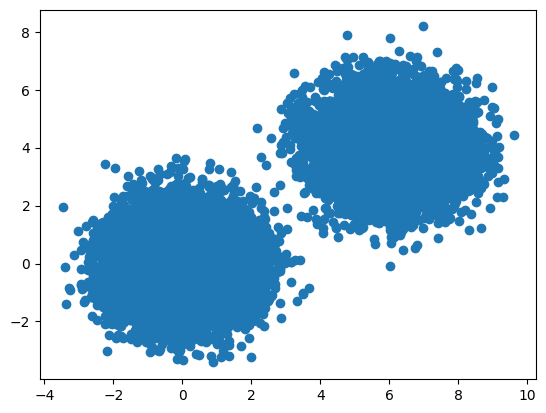

In [7]:
def deux_bosses(mean_1, mean_2, cov_1, cov_2, n):
    data_1 = np.random.multivariate_normal(mean_1, cov_1, size=n//2)
    data_2 = np.random.multivariate_normal(mean_2, cov_2, size=n//2)
    return np.concatenate((data_1, data_2))

samples = deux_bosses([0, 0], [6, 4], [[1, 0], [0, 1]], [[1, 0], [0, 1]], 20000)
plt.scatter(samples[:,0], samples[:,1])

In [8]:
#split dataset in train and test

X_train, X_test = train_test_split(samples,test_size=.33, random_state=26)

In [9]:
#enables to create different batches instead of treating whole dataset taking too much CPU

# Convert data to torch tensors
class Data():
    def __init__(self, X):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index]

    def __len__(self):
        return self.len

In [10]:
#set batch size for first model
batch_size = 100

# Instantiate training and test data
train_data = Data(X_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, X in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    break

Batch: 1
X shape: torch.Size([100, 2])


In [12]:
mean = torch.Tensor([0,0])
cov2 = torch.Tensor([[1, 0], [0, 1]])
distrib = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=cov2)
distrib.rsample(sample_shape=torch.Size([100, 2]))

tensor([[[ 2.6024e-02, -7.0425e-01],
         [-1.5772e-01,  1.2077e+00]],

        [[ 1.0119e+00,  1.1378e+00],
         [-2.3411e-02,  9.2641e-02]],

        [[ 4.1252e-01, -9.3722e-01],
         [ 2.2619e+00, -2.4740e+00]],

        [[ 9.5428e-01,  1.6339e-02],
         [-9.9261e-01,  5.5390e-01]],

        [[ 7.2567e-01,  6.7244e-01],
         [ 2.2569e-01, -9.3631e-02]],

        [[ 2.0904e-01, -1.1111e+00],
         [ 2.6331e-01, -5.8624e-01]],

        [[ 2.2148e+00, -2.0909e-01],
         [ 2.2278e-01,  1.0301e-01]],

        [[ 6.1640e-01,  1.3880e+00],
         [ 8.1635e-02, -9.6516e-01]],

        [[ 1.4312e+00, -1.6035e+00],
         [ 1.8153e+00, -1.7655e-01]],

        [[-1.7465e-01, -1.8937e+00],
         [ 1.7124e+00, -4.1682e-01]],

        [[ 1.8192e+00, -1.3160e+00],
         [-2.5391e-01,  2.0114e-01]],

        [[ 2.6583e-01,  7.5219e-01],
         [ 2.7244e-01, -1.6771e-01]],

        [[-7.9372e-01,  1.0049e+00],
         [-1.1556e+00, -7.5814e-03]],

        [[-1

In [13]:
# neuronal network for gradient

input_dim_grad = 2       #input layer with 2 neurons
hidden_dim_grad = 10     #hidden layer with 10 neurons
output_dim_grad = 2      #output layer with 1 neuron

class NeuralNetworkGrad(nn.Module):
    def __init__(self, input_dim_grad, hidden_dim_grad, output_dim_grad):
        super(NeuralNetworkGrad, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.layer_1 = nn.Linear(input_dim_grad, hidden_dim_grad)
        self.layer_2 = nn.Linear(hidden_dim_grad, output_dim_grad)

    def forward(self, x):
        #prend max(0,x)
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.dropout(x) #apply dropout correctly
        #do not use the sigmoid activation function for the second layer anymore.
        #gradients can be positive or negative -> they do not take values only between 0 and 1!
        #sigmoid prevents the model from learning correct gradients with negative values.
        x = self.layer_2(x)

        return x

#instantiate a model of NN class
modelGrad = NeuralNetworkGrad(input_dim_grad, hidden_dim_grad, output_dim_grad)
print(modelGrad)

#alpha = step-size in direction of gradient
learning_rate = 0.01
#loss function giving error between real and estimated data
loss_fn = nn.MSELoss()

optimizer_grad = torch.optim.SGD(modelGrad.parameters(), lr=learning_rate)

NeuralNetworkGrad(
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=2, bias=True)
)


In [14]:
#Train the model
num_epochs = 1
loss_values_grad = []

for epoch in range(num_epochs):
    print(epoch)
    for X in train_dataloader:

        # zero the parameter gradients

        optimizer_grad.zero_grad()

        # forward + backward + optimize
        bruit=distrib.rsample(sample_shape=torch.Size([X.shape[0]]))
        pred = modelGrad(X+bruit)
        loss = loss_fn(pred,-bruit)
        loss_values_grad.append(loss.item())
        loss.backward()
        optimizer_grad.step()

print("Training Complete")

0
Training Complete


In [15]:
modelGrad(torch.Tensor([0,4]))

tensor([ 0.5841, -0.4094], grad_fn=<AddBackward0>)

In [16]:
point=torch.Tensor([[0,4]])
mu1=torch.Tensor([[0.01, 0],[0, 0.01]])
mean = torch.Tensor([0,0])
distrib = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=mu1)

In [ ]:
def torch_ls(fon, p, n, epsi):
    point = p
    tensor = point
    mu1=torch.Tensor([[epsi, 0],[0, epsi]])
    mean = torch.Tensor([0,0])
    distrib = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=mu1)
    for i in range(n):
        point = point + fon(point) + distrib.rsample(sample_shape=torch.Size([point.shape[0]]))
        print(point)
        print(tensor)
        tensor=torch.cat((tensor,point))

    return tensor

liste2=torch_ls(modelGrad,torch.Tensor([[0,4],[2,3]]),100,0.01)